In [1]:
from tope import Tope
from tope.net import *
from tope.orth import *
from tests import normalize_polygon
from typing import *

import json, os, numpy as np
rng = np.random.default_rng()
with open("polys.json") as fd: polys = json.load(fd)
    
logger.remove()

Bbox(x0=0.0, y0=0.0, x1=1.0, y1=1.0)


'auto'

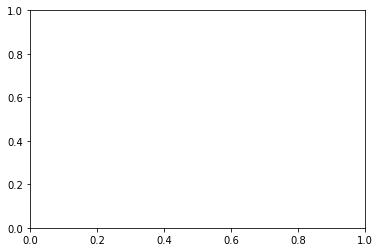

In [91]:
fig,ax = plt.subplots()
print(ax.viewLim)
ax.get_aspect()

In [2]:
v_24cell = [
    [1, 0, 0, 0], [-1, 0, 0, 0],
    [0, 1, 0, 0], [0, -1, 0, 0],
    [0, 0, 1, 0], [0, 0, -1, 0], 
    [0, 0, 0, 1], [0, 0, 0, -1],
    [1, -1, 0, 0], [-1, 1, 0, 0], 
    [1, 0, -1, 0], [-1, 0, 1, 0], 
    [1, 0, 0, -1], [-1, 0, 0, 1], 
    [0, 1, -1, 0], [0, -1, 1, 0], 
    [0, 1, 0, -1], [0, -1, 0, 1],
    [1, 0, -1, -1], [-1, 0, 1, 1], 
    [0, 1, -1, -1], [0, -1, 1, 1],
    [1, 1, -1, -1], [-1, -1, 1, 1]
]

In [3]:
v_36cell = [
    (1, 0, 0, 0),
    (0, 0, 1, 0),
    (0, -1, 0, 0),
    (0, 0, 0, -1),
    (1, 1, 0, 0),
    (-1, -1, 0, 0),
    (0, 1, 0, 0),
    (-1, 0, 0, 0),
    (0, 0, 1, 1),
    (0, 0, 0, 1),
    (0, 0, -1, -1),
    (0, 0, -1, 0)
]

In [4]:
EdgeList = list[np.ndarray] # list of 2xdim arrays

def get_cuts(N: Net) -> EdgeList:
    return np.concatenate([N.tope.meta[2][i]["cuts"] for i in range(len(N.facets))])
        
        
def get_edges(N: Net) -> EdgeList: # apply to unfolded Net
    edges = []
    for i, vertices in N.facets.items():
        facet_template = N.tope.get_face(i) # has correct indices
        edges.extend((vertices[list(e)] for e in facet_template.faces[1]))
    return edges

import itertools

Net2d = None # new format of Net

def iter_edges(N: Net2d) -> Iterable[np.ndarray[2,2]]: # apply to unfolded 2d Net
    return N.iter_faces_as_vertices(dim=1)

FacetLabels = list[tuple[str, np.ndarray]] # label, position

def get_facet_labels(N: Net) -> FacetLabels:
    labels = []
    for i, vertices in N.facets.items():
        labels.append((N.tope.meta[N.tope.dim-1][i]["index"], vertices.mean(axis=0)))
    return labels

def iter_facet_labels(N: Net2d, key: str) -> Iterable[str]:
    return zip(N.iter_meta(dim=2, key="index"), map(N.cells.values(), lambda x: x.vertices.mean(axis=0)))

In [5]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection # container for line segments
from matplotlib.text import Text, Annotation
import matplotlib.cm as cm # colour mappings
import matplotlib as mpl

In [6]:
def get_net_for_facet(P: Tope, i: int, keys=[]) -> Net:
    F = P.get_facet(i, meta_keys=keys)
    G = get_facet_graph(F)
    T = G.get_spanning_tree()
    N = Net(F, T).unfold_with_meta(meta_keys=keys).in_own_span(meta_keys=keys)
    return N

In [7]:
MARGIN_FACTOR = 1.1

from tope.plot import bounding_bbox, set_view, plot_in_view

def plot_nets(
    P: Tope, 
    name: str, 
    margin_factor: float = MARGIN_FACTOR, 
    dpi: int = 300, 
    force=False, 
    fmt="svg",
    label_config: dict = {"fontsize": 2, "ha": "center", "va": "center"},
    title_config: dict = {"fontsize": 8, "pad": -14},
    hatch = False,
    label = True
):
    mkdir_parents(name) if force else os.mkdir(name)
    
    nfacets = len(P.faces[P.dim-1])
    nets = [get_net_for_facet(P, i, keys=["cuts"]) for i in range(nfacets)] if hatch \
        else [get_net_for_facet(P, i) for i in range(nfacets)]
    
    ## compute common bounding box
    
    bbox = bounding_bbox(*(cell for N in nets for cell in N.facets.values()))
    
    #xlim, ylim = compute_bounding_box(*(cell for N in nets for cell in N.facets.values()), margin_factor=margin_factor)
    
    ## generate images
    figs = []
    for i, N in enumerate(nets):
        artists = [LineCollection(get_edges(N), colors="grey", linewidths=0.2)]
        
        if hatch: artists.append(
            LineCollection(get_cuts(N), colors="lightgrey", linewidths=0.05)
        )
            
        if label: artists.append(
            Text(*pos, text=str(l), **label_config) for l, pos in get_facet_labels(N)
        )
        
        # draw the actual picture
        fig, _ = plot_in_view(artists, bbox = bbox, margin = margin)
        
        # title with "default" positioning
        ax.set_title(f"{name}-facet-{i}", **title_config)
                
        # store and next()
        figs.append((str(i), fig))
    
    return figs

In [8]:
def get_hyperplanes(*planes, spacing=0.2, r=5):
    return [H for L in planes for H in [(L, i*L) for i in np.arange(-r, r, spacing)]]

hyperplanes = get_hyperplanes(
    *(rng.integers(-5,5,size=4) for _ in range(4)), spacing=0.005
#    *(rng.normal(size=4) for _ in range(4))
#    np.array([1,0,0,0]), np.array([0,1,0,0]), np.array([0,0,1,0]), np.array([0,0,0,1])
)

In [9]:
P = Tope.from_vertices(v_36cell)
P.save_index()
P.cut_2faces_with_hyperplanes(hyperplanes)
nets = plot_nets(P)

from tope.plot import save_figs_to_dir, save_figs_to_zip
save_figs_to_zip(nets, force=True, fmt="png", dpi=600)
#save_nets(P, "figs/4902603", force=True, fmt="svg")

<ipython-input-7-7c54c9fad857>:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


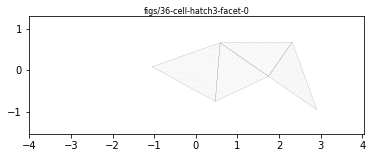

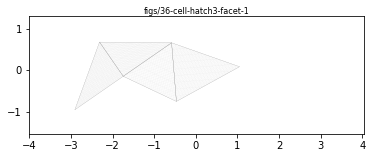

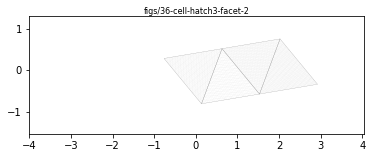

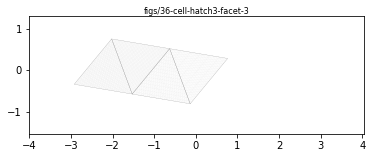

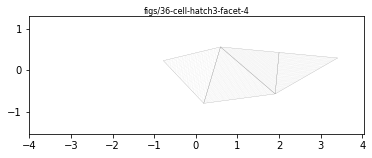

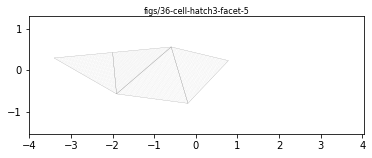

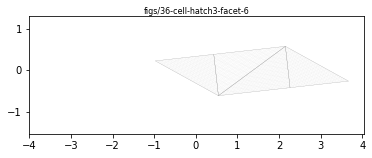

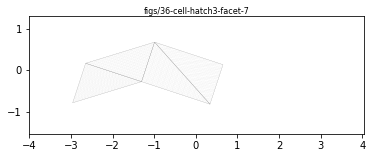

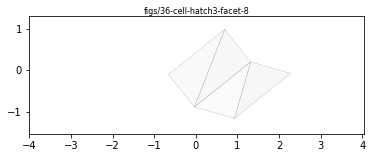

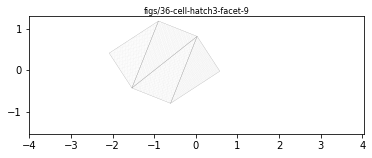

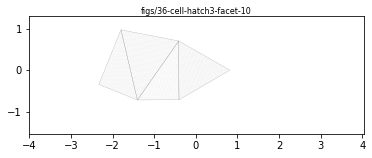

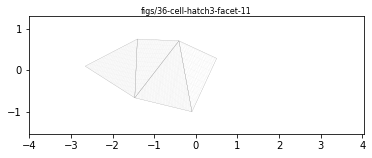

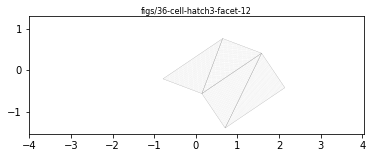

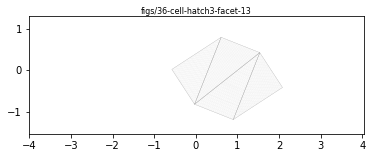

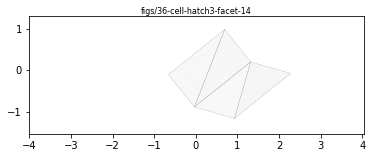

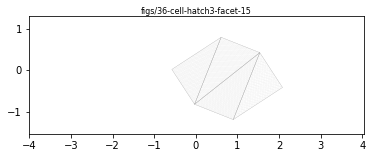

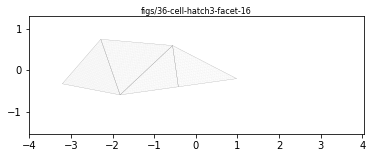

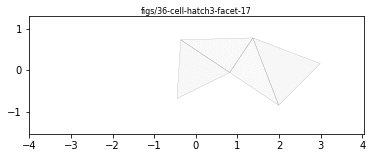

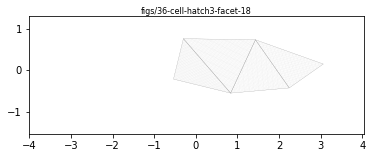

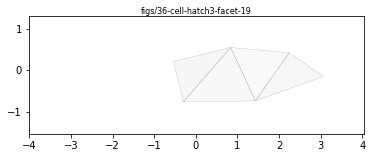

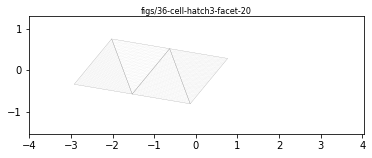

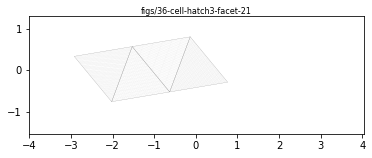

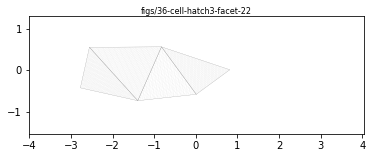

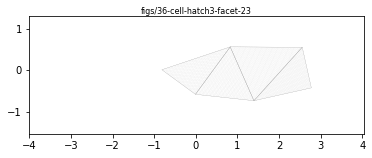

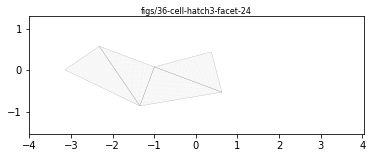

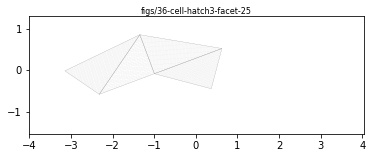

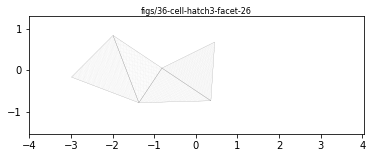

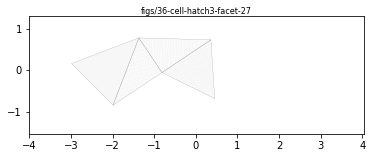

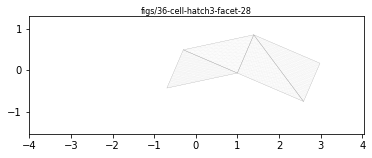

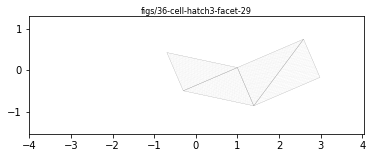

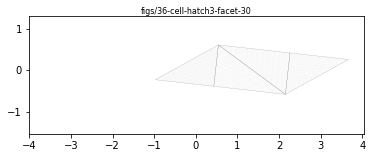

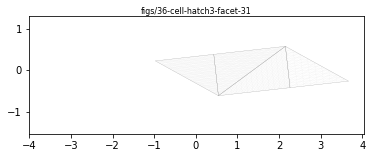

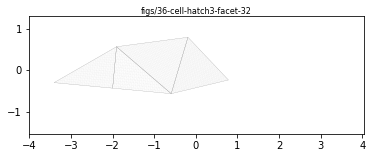

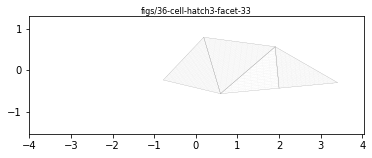

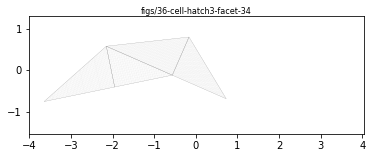

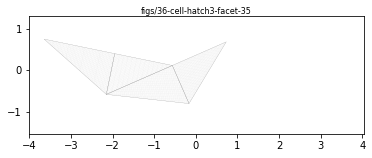

In [11]:
save_nets(P, "figs/36-cell-hatch3", force=True, hatch=True, label=False, fmt="png", dpi=1200)

In [ ]:
P = Tope.from_vertices(v_24cell)
P.save_index() # now must do this before passing to sub-topes
P.cut_2faces_with_hyperplanes(hyperplanes) # and this
save_nets(P, "figs/24cell", force=True)

In [ ]:
P = Tope.from_vertices(polys["2070"])
P.save_index() # now must do this before passing to sub-topes
save_nets(P, "figs/2070", force=True)

In [ ]:
#save_nets(Tope.from_vertices(polys["2070"]), "figs/2070", force=True)

In [ ]:
for name, poly in polys.items():
    save_nets(Tope.from_vertices(poly), f"figs/{name}", force=True)

In [90]:
with open("../polys1.json") as fd: data = json.load(fd)

In [91]:
v_bigboy = data["4902603"]